# Inverse Design Integrated with Circuit Simulation

In this tutorial, we will show how to integrate the `adjoint` plugin of `Tidy3D` with a differentiable optical circuit simulator `sax`. This allows one to model a complicated circuit composed of many connected components, each simulated independently using `Tidy3D`. Through the `adjoint` plugin and `jax`, the gradients of all of the indivual components are similarly connected. This allows one to write an objective function in terms of the scattering matrix of the entire circuit and optimize this function with respect to the design parameters in each of the individual `Tidy3D` simulations.

To demonstrate this capability, in this notebook we optimize a Mach-Zehnder Interferometer (MZI) circuit. This simplified MZI has a single input and two outputs. We wish to switch the transmitted power between the two outputs depending on a phase shift applied to a waveguide in the system. We set up our circuit to have a single splitter component that takes the input light and splits it into two waveguides, we apply the phase shift to one of these waveguides, and then add a component that combines the light from the two waveguides, mixes it together, and sends it to our two outputs. The scattering matrix of the two components are computed using `Tidy3D` simulations and the waveguide connections and phase shifter are defined using the `sax` circuit simulator. As all of the gradients are passed automatically through `jax`, we then optimize our circuit with respect to the permittivity distributions in each of the two `Tidy3D` simulations simultaneously.

> To install the `jax` module required for this feature, we recommend running `pip install "tidy3d[jax]"`. You will also need to `pip install sax`.

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).

## Setup

First we import all of the packages we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import sax

import tidy3d as td
import tidy3d.plugins.adjoint as tda

np.random.seed(2)

/Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sax/backends/__init__.py:24: UserWarning: klujax not found. Please install klujax for better performance during circuit evaluation!
  warnings.warn(


### Tidy3D Simulation Parameters
Then we will initialize some parameters needed for our individual component simulations.

For this application, we model each of the `Tidy3D` components as square design regions accepting 1 or 2 inputs and transmitting to 1 or 2 outputs.

In [2]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength
k0 = 2 * np.pi * freq0 / td.C_0

# resolution control
steps_per_wvl = 20

# space between boxes and PML
buffer = 1.0 * wavelength

# optimize region size
lz = td.inf
lx = 4.0
ly = lx
wg_width = 0.4

# num cells
nx = 120
ny = nx
num_cells = nx * ny

# position of source and monitor (constant for all)
source_x = -lx / 2 - buffer * 0.8
meas_x = lx / 2 + buffer * 0.8

# total size
Lx = lx + 2 * buffer
Ly = ly + 2 * buffer
Lz = 0

# permittivity info
eps_wg = 2.75
eps_deviation_random = 0.5
eps_max = 5

# note, we choose the starting parameters
params0 = np.random.random((nx, ny))

# frequency width and run time
freqw = freq0 / 10
run_time = 50 / freqw

Because we want to be able to model a general system of 1 or 2 inputs coupling to 1 or 2 outputs, we pre-define all of the possible waveguide configurations beforehand to make things simpler later.

In [3]:
big_number = Lx * 10

dy = (ly - 2 * wg_width) / 4 + wg_width/2

# all of the possible input and output waveguides
waveguide_in_center = td.Structure(
    geometry=td.Box(
        size=(big_number, wg_width, lz),
        center=(-big_number/2, 0, 0),
    ),
    medium=td.Medium(permittivity=eps_wg)
)

waveguide_in_top = td.Structure(
    geometry=td.Box(
        size=(big_number, wg_width, lz),
        center=(-big_number/2, +dy, 0),
    ),
    medium=td.Medium(permittivity=eps_wg)
)

waveguide_in_bot = td.Structure(
    geometry=td.Box(
        size=(big_number, wg_width, lz),
        center=(-big_number/2, -dy, 0),
    ),
    medium=td.Medium(permittivity=eps_wg)
)

waveguide_out_center = td.Structure(
    geometry=td.Box(
        size=(big_number, wg_width, lz),
        center=(+big_number/2, 0, 0),
    ),
    medium=td.Medium(permittivity=eps_wg),
    name="center"
)

waveguide_out_top = td.Structure(
    geometry=td.Box(
        size=(big_number, wg_width, lz),
        center=(+big_number/2, +dy, 0),
    ),
    medium=td.Medium(permittivity=eps_wg),
    name="top"
)

waveguide_out_bot = td.Structure(
    geometry=td.Box(
        size=(big_number, wg_width, lz),
        center=(+big_number/2, -dy, 0),
    ),
    medium=td.Medium(permittivity=eps_wg),
    name="bot"
)

We also define some information about our mode source and monitor geometries.

In [4]:
# the source and measurement plane size
mode_size = (0, wg_width * 3, lz)

# source plane centered at y=0
source_plane_base = td.Box(
    center=[source_x, 0, 0],
    size=mode_size,
)

def get_source_plane(waveguide: td.Structure) -> td.Box:
    """SOurce plane with y position moved to cover a specific waveguide"""
    return source_plane_base.updated_copy(center=(source_x, waveguide.geometry.center[1], 0))

measure_plane = td.Box(
    center=[meas_x, 0, 0],
    size=mode_size,
)

### Design Parameterization
As in many of the other `adjoint` demos, now we define our design region structure using a `JaxCustomMedium` generated as a function of our design parameters. We will apply filtering and projection to create smooth features. For more details, we refer the reader to our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/).

In [5]:
from tidy3d.plugins.adjoint.utils.filter import ConicFilter, BinaryProjector
from typing import List

radius = .120
beta = 50

conic_filter = ConicFilter(radius=radius, design_region_dl=float(lx) / nx)

def tanh_projection(x, beta, eta=0.5):
    tanhbn = jnp.tanh(beta * eta)
    num = tanhbn + jnp.tanh(beta * (x - eta))
    den = tanhbn + jnp.tanh(beta * (1 - eta))
    return num / den    

def filter_project(x, beta, eta=0.5):
    x = conic_filter.evaluate(x)
    return tanh_projection(x, beta=beta, eta=eta)

def pre_process(params, beta):
    """Get the permittivity values (1, eps_wg) array as a funciton of the parameters (0,1)"""
    params1 = filter_project(params, beta=beta)
    params2 = filter_project(params1, beta=beta)
    return params2

def get_eps(params, beta):
    params = pre_process(params, beta=beta)
    eps_min = 1.0001
    eps_values = eps_min + (eps_wg - eps_min) * params
    return eps_values
    
def make_input_structures(params, beta) -> List[tda.JaxStructure]:

    size_box_x = float(lx) / nx
    size_box_y = float(ly) / ny
    size_box = (size_box_x, size_box_y, lz)

    x0_min = -lx / 2 + size_box_x / 2
    y0_min = -ly / 2 + size_box_y / 2

    input_structures = []

    coords_x = [x0_min + index_x * size_box_x - 1e-5 for index_x in range(nx)]
    coords_y = [y0_min + index_y * size_box_y - 1e-5 for index_y in range(ny)]

    coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq0])

    eps_boxes = get_eps(params, beta=beta).reshape((nx, ny, 1, 1))

    field_components = {
        f"eps_{dim}{dim}": tda.JaxDataArray(values=eps_boxes, coords=coords) for dim in "xyz"
    }
    eps_dataset = tda.JaxPermittivityDataset(**field_components)
    custom_medium = tda.JaxCustomMedium(eps_dataset=eps_dataset)
    box = tda.JaxBox(center=(0, 0, 0), size=(lx, ly, lz))
    custom_structure = tda.JaxStructure(geometry=box, medium=custom_medium)
    return [custom_structure]


### Base Simulation
Next, we write a "base" simulation (without sources or monitors) as a function of our input parameters. We also accept the `shape` of our component, which specifies the number of inputs and outputs. This determines which waveguides we add to our simulation.

In [6]:
def make_sim_base(params, beta, shape) -> tda.JaxSimulation:

    input_structures = make_input_structures(params, beta=beta)

    num_wg_in, num_wg_out = shape
    if num_wg_in == 1:
        wgs_in = [waveguide_in_center]
    else:
        wgs_in = [waveguide_in_top, waveguide_in_bot]

    if num_wg_out == 1:
        wgs_out = [waveguide_out_center]
    else:
        wgs_out = [waveguide_out_top, waveguide_out_bot]
    
    return tda.JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=steps_per_wvl, wavelength=wavelength),
        structures=wgs_in + wgs_out,
        input_structures=input_structures,
        sources=[],
        monitors=[],
        output_monitors=[],
        run_time=run_time,
        subpixel=True,
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
        shutoff=1e-8,
        courant=0.9,
    )


Let's make a base simulation for a few different shapes and plot them to make sure they work properly.

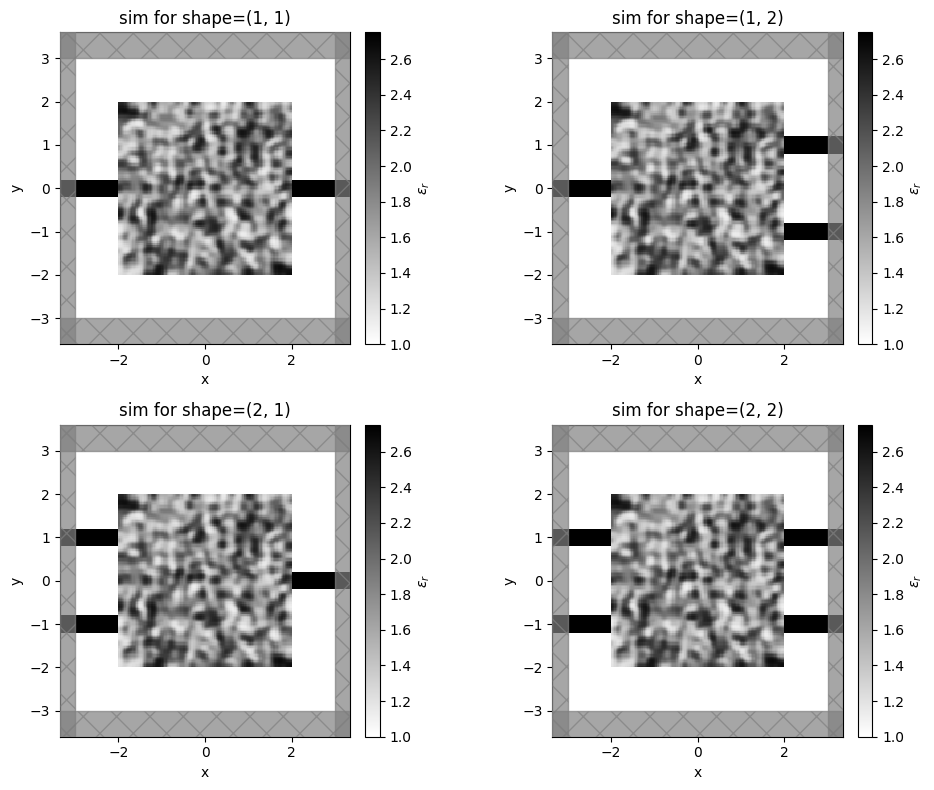

In [7]:
f, ((ax1, ax2), (ax3, ax4)) = f, (axtop, axbot) = f, axes = plt.subplots(2, 2, tight_layout=True, figsize=(10,8))

for num_in in (1,2):
    for num_out in (1,2):
        ax = axes[num_in - 1, num_out-1]
        shape = (num_in, num_out)
        sim = make_sim_base(params0, beta=5.0, shape=shape)
        _ = sim.plot_eps(z=0, ax=ax)
        ax.set_title(f"sim for shape={shape}")
        
plt.show()

### Mode Solver
Next, we'll run the mode solver on one of these waveguides to make sure we inject and measure the desired waveguide modes in our system.

In [8]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver
num_modes = 4
mode_spec = td.ModeSpec(num_modes=num_modes)

sim_start = make_sim_base(params0, beta=5.0, shape=(1,1))

mode_solver = ModeSolver(
    simulation=sim_start.to_simulation()[0],
    plane=get_source_plane(sim_start.structures[0]),
    mode_spec=td.ModeSpec(num_modes=num_modes),
    freqs=[freq0]
)
modes = run_mode_solver(mode_solver)

[12:02:19] Mode solver created with                                             
           task_id='fdve-9b67d02f-bef8-4cfd-8624-cc8ff71181a0v1',               
           solver_id='mo-f0b71b91-562c-40b6-98fc-0668913b6045'.

Output()

Output()

[12:02:23] Mode solver status: queued

[12:02:25] Mode solver status: running

[12:02:36] Mode solver status: success

Output()

Let's plot the modes.

Effective index of computed modes:  [[1.4718899  1.3554943  1.0077018  0.93306565]]


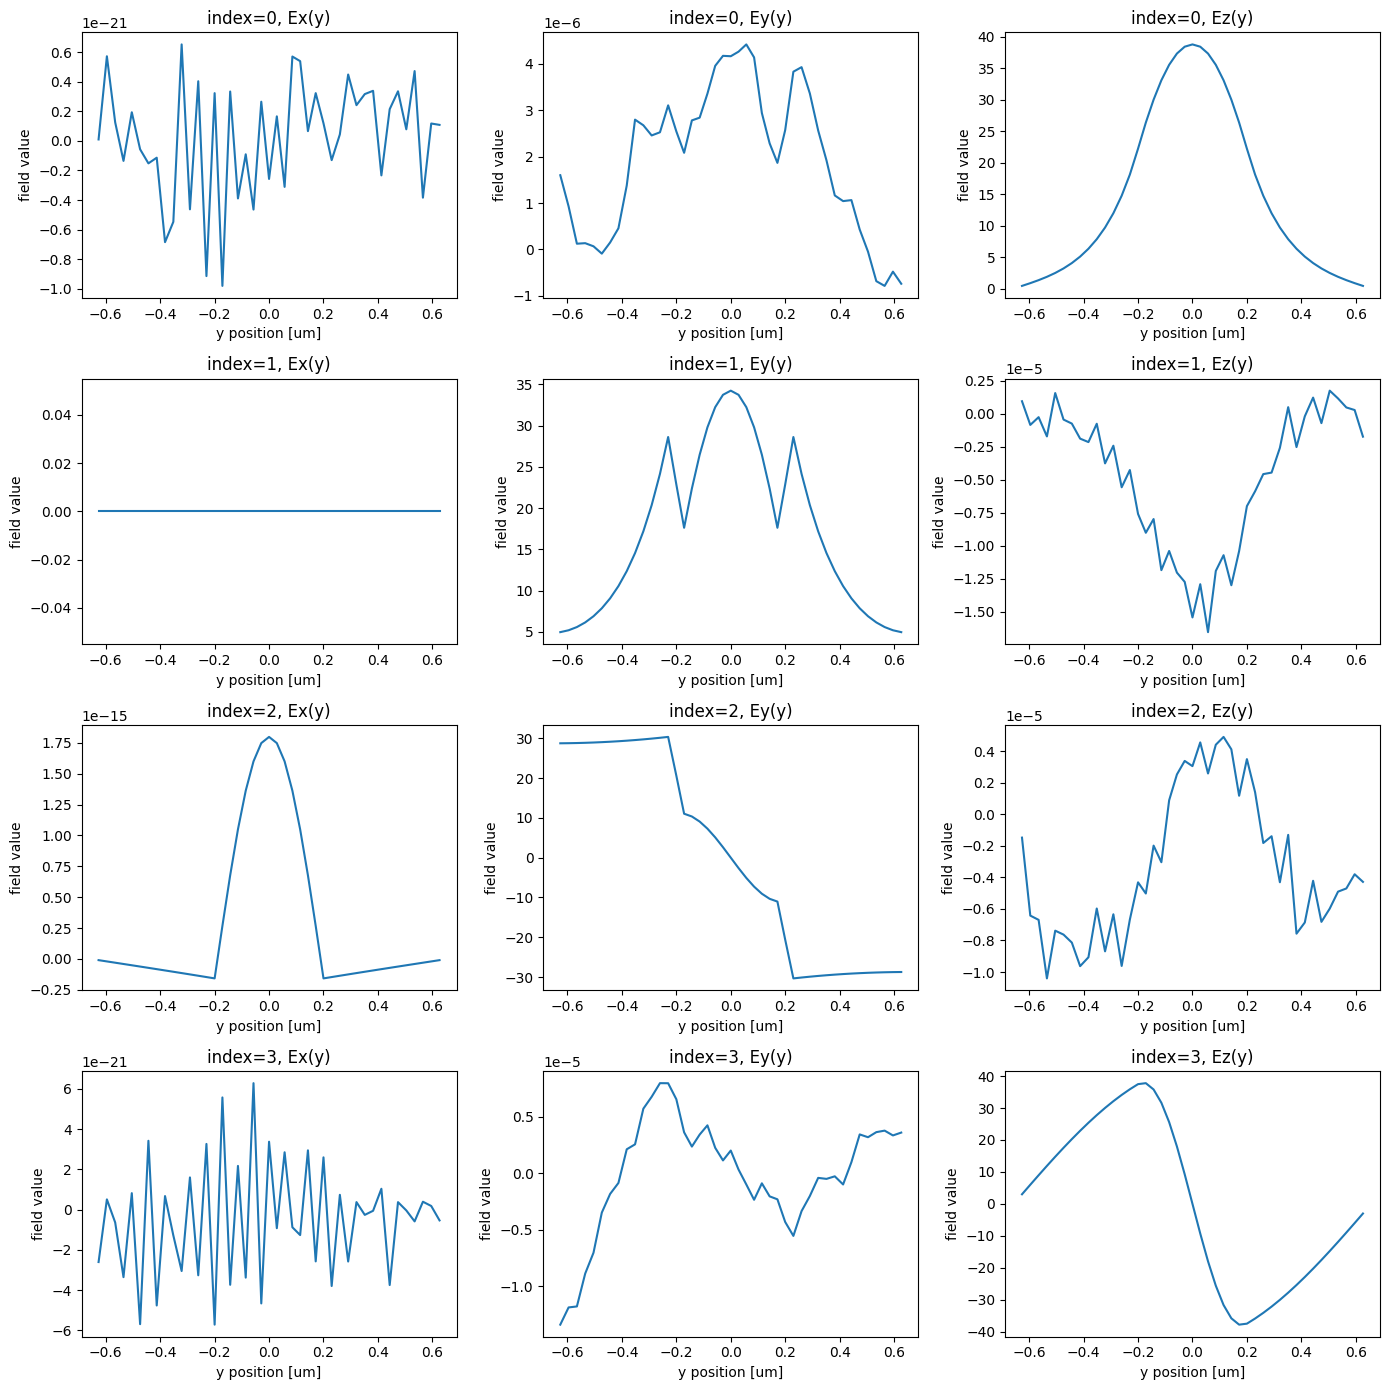

In [9]:
print("Effective index of computed modes: ", np.array(modes.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(14, 14), tight_layout=True)
for mode_ind in range(num_modes):
    for field_ind, field_name in enumerate(("Ex", "Ey", "Ez")):
        field = modes.field_components[field_name].sel(mode_index=mode_ind)
        ax = axs[mode_ind, field_ind]
        field.real.plot(ax=ax)
        ax.set_title(f'index={mode_ind}, {field_name}(y)')

We wish to inject the fundamental `Ez`-polarized mode, which is given by `mode_index=0` above. Thus, we make a variable to store this and re-set the `ModeSpec.num_modes` to account for this `index` without being too high, which could waste computation.

In [10]:
mode_index = 0
num_modes = mode_index + 1

mode_spec = td.ModeSpec(num_modes=num_modes)

### Sources and Monitors

Next we will define our input sources and output monitors for this component. We'll write these as functions of the intput and output waveguides so the process of generating them is more general.

In [11]:
def make_source(waveguide):

    # source seeding the simulation
    return td.ModeSource(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
        center=[source_x, waveguide.geometry.center[1], 0],
        size=mode_size,
        mode_index=mode_index,
        mode_spec=mode_spec,
        direction="+",
    )

def make_output_monitors(waveguides):

    monitors = []

    for waveguide in waveguides:

        # monitor where we compute the objective function from
        measurement_monitor = td.ModeMonitor(
            center=[meas_x, waveguide.geometry.center[1], 0],
            size=mode_size,
            freqs=[freq0],
            mode_spec=mode_spec,
            name=waveguide.name,
        )
        monitors.append(measurement_monitor)

    return monitors


### Final Simulation

Finally, we write a function to generate a component simulation based on the design parameters, projection strength, shape (inputs x outputs), and the index of the source we wish to inect into.

In [12]:
def make_sim(params, beta, shape, source_index: int):
    sim = make_sim_base(params, beta=beta, shape=shape)
    num_wgs_in, num_wgs_out = shape

    wg_in = sim.structures[source_index]
    forward_source_in = make_source(wg_in)

    wgs_out = list(sim.structures)[int(num_wgs_in):]
    output_monitors = make_output_monitors(wgs_out)

    return sim.updated_copy(
        sources=[forward_source_in],
        output_monitors=output_monitors
    )

Let's generate a simulation and plot it with the sources and monitors to make sure it worked properly.

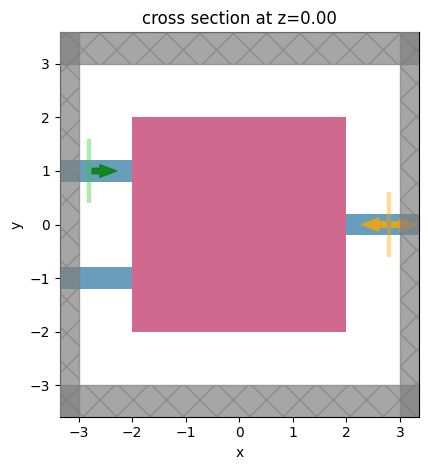

In [13]:
ax = make_sim(params0, shape=(2,1), beta=1, source_index=0).plot(z=0)

## Defining Circuit

With our function to generate the component simulations, now we can start focusing on combining these components together into a circuit using `sax`. We highly recommend referring to the `sax` [documentation](https://flaport.github.io/sax/) for any additional information, but will give a brief tutorial of the tool through the next few cells.

### Components

In `sax`, the individual "nodes" in the circuit are defined as functions that return the scattering matrix of that component as a dictionary. In our case, our individual components are modelled as `Tidy3D` simulations. Therefore, we will write our component function to accept the design parameters and run one `Tidy3D` simulation per input source to construct the scattering matrix of the system.

In [14]:
def component(params=params0, beta=5, shape=(2,2)):

    num_in, num_out = shape
    num_in = int(num_in)
    num_out = int(num_out)
    
    def get_S_column(sim_data):
        """Compute a column of the scattering matrix for a single dataset."""  
        outputs = []
        for out_mnt in sim_data.simulation.output_monitors:
            amps = sim_data[out_mnt.name].amps
            amp = jnp.sum(amps.sel(mode_index=mode_index, direction="+", f=freq0))
            outputs.append(amp)
        return outputs

    sims = [make_sim(params, shape=shape, beta=beta, source_index=source_index) for source_index in range(num_in)]
    sim_datas = tda.web.run_async(sims, verbose=False, path_dir="data")

    s_columns = [get_S_column(sim_data) for sim_data in sim_datas]
    
    # assemble the scattering matrix
    s_dict = {}
    for index_in in range(num_in):
        label_in = "in" + str(index_in)
        s_col = s_columns[index_in]
        for index_out in range(num_out):
            label_out = "out" + str(index_out)
            s_element = s_col[index_out]
            s_dict[(label_in, label_out)] = s_element

    return sax.reciprocal(s_dict)


> Note: these component functions must only contain keyword arguments (like `x=1`) with default values. So we define `params=params0` and `beta=5` as defaults for now, but will show how to pass our own values later.

Let's test this out by calling this function with some example inputs and visualizing the s-matrix.

We see that it returns a dictionary where the keys are tuples mapping the names of our input waveguide to our output waveguide.

In [15]:
component_sdict = component(params0, beta=1, shape=(1,2))
component_sdict

{('in0', 'out0'): Array(-0.34157267+0.19757959j, dtype=complex64),
 ('in0', 'out1'): Array(-0.33023015+0.1939034j, dtype=complex64),
 ('out0', 'in0'): Array(-0.34157267+0.19757959j, dtype=complex64),
 ('out1', 'in0'): Array(-0.33023015+0.1939034j, dtype=complex64)}

Next, we define a more simple component function to model our phase shifter. This component simply takes the phase value `phi` and adds it to the connection.

In [16]:
def phase_shifter(phi: float = 0.0):
    phase_added = jnp.exp(1j * phi)
    s_dict = {("in", "out"): phase_added}
    return sax.reciprocal(s_dict)

### Circuit

Next, we need to combine these components together into a circuit. We do this through `sax.circuit`, which lets us define our "instances" (these component functions defined earlier), the "connections" between each of these instances, and then the "ports" for the entire circuit.

We wish to create a (1->2) component, with one output connected to our phase shifter, and then combine everything in a (2->2) component. We define these components and connections below and then specify the ports for the entire S-matrix, which is a (1->2) system.

In [17]:
import functools

circuit_fn, _ = sax.circuit(
    netlist={
        "instances": {
            "splitter": functools.partial(component, shape=(1,2)),
            "phase_shifter": phase_shifter,
            "combiner": functools.partial(component, shape=(2,2)),
        },
        "connections": {
            "splitter,out0": "phase_shifter,in",
            "phase_shifter,out": "combiner,in0",
            "splitter,out1": "combiner,in1",
        },
        "ports": {
            "in": "splitter,in0",
            "out0": "combiner,out0",
            "out1": "combiner,out1",
        },
    }
)
circuit_fn

<function sax.circuit._flat_circuit.<locals>._circuit(*, splitter={'params': Array([[0.4359949 , 0.02592623, 0.5496625 , ..., 0.17671216, 0.59125733,
        0.48926616],
       [0.54790777, 0.69952065, 0.24581116, ..., 0.6424524 , 0.38690034,
        0.85511965],
       [0.3807926 , 0.17830983, 0.7816594 , ..., 0.4921191 , 0.9379131 ,
        0.13442676],
       ...,
       [0.35449517, 0.7365258 , 0.73508275, ..., 0.62516195, 0.26062906,
        0.5743313 ],
       [0.87019104, 0.9364767 , 0.56900996, ..., 0.47169012, 0.08907937,
        0.9284895 ],
       [0.25833175, 0.5660962 , 0.85214543, ..., 0.31971204, 0.79901004,
        0.170014  ]], dtype=float32), 'beta': Array(5., dtype=float32), 'shape': Array([1., 2.], dtype=float32)}, phase_shifter={'phi': Array(0., dtype=float32)}, combiner={'params': Array([[0.4359949 , 0.02592623, 0.5496625 , ..., 0.17671216, 0.59125733,
        0.48926616],
       [0.54790777, 0.69952065, 0.24581116, ..., 0.6424524 , 0.38690034,
        0.85511965

### Passing individual parameters

The `circuit_fn` returned is a function that accepts parameters to each of our component functions. It is worth noting that we can pass different inputs to different functions by passing them as keyword arguments, as shown below. This is important to note as we will be optimizing each of the `Tidy3D` components individually with their own independent parameters.

Let's call the circuit function and print the result, which is the S-matrix for the entire circuit given our passed parameters.

In [18]:
# how to pass specific parmaeters to each of the sub-functions for the instances
s = circuit_fn(splitter={"params": params0}, combiner={"params": 0 * params0}, beta=3, phase_sifter=dict(phi=2.0))


In [19]:
s

{('out1', 'out1'): Array(0.+0.j, dtype=complex64),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex64),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex64),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex64),
 ('in', 'in'): Array(0.+0.j, dtype=complex64),
 ('in', 'out1'): Array(-0.00776622+0.06118518j, dtype=complex64),
 ('in', 'out0'): Array(0.00377436+0.06984529j, dtype=complex64),
 ('out1', 'in'): Array(-0.00776622+0.06118518j, dtype=complex64),
 ('out0', 'in'): Array(0.00377436+0.06984529j, dtype=complex64)}

## Objective Function

With our circuit defined, we can now combine everything into a single objective function. We first write a `penalty` function that evaluates how well the structure respects the feature size constraints that we defined earlier.

In [20]:
def penalty(params, beta, delta_eps=0.49):
    params = pre_process(params, beta=beta)
    dilate_fn = lambda x: filter_project(x, beta=100, eta=0.5-delta_eps)
    eroded_fn = lambda x: filter_project(x, beta=100, eta=0.5+delta_eps)

    params_dilate_erode = eroded_fn(dilate_fn(params))
    params_erode_dilate = dilate_fn(eroded_fn(params))
    diff = params_dilate_erode - params_erode_dilate
    return jnp.linalg.norm(diff) / jnp.linalg.norm(jnp.ones_like(diff))

We then write a combined objective function that accepts our parameters for each of the individual components (as one array `params`) and the projection strength `beta` applied to each design region.

The objective function uses these parameters to construct each of the individual components and simulates them to compute their scattering matrix. Then, it defines a circuit-level objective to look at the transmission of the entire circuit into the two output ports as a function of the phase shift `phi`. We seek to maximize transmission to the top port when `phi=0` and the bottom port when `phi=pi`.

In [21]:
def J(params, beta) -> float:
    """Circuit-level objective function."""

    params1, params2 = params
    
    circuit_function = functools.partial(circuit_fn, splitter={"params": params1}, combiner={"params": params2}, beta=beta)
    
    def top_minus_bot(phi: float) -> float:
        """Power in top port minus power in bottom port."""

        #evaluate the circuit at phi
        sdict = circuit_function(phase_shifter={"phi": phi})
    
        # S-parameters for the whole circuit
        s_00 = sdict["in", "out0"]
        s_01 = sdict["in", "out1"]

        # power at ports
        power_top = jnp.sum(jnp.abs(s_00)**2)
        power_bot = jnp.sum(jnp.abs(s_01)**2)
        
        # top power minus bottom power
        return power_top - power_bot

    # combine objectives together: at worst, it will be -1, at best + 1.
    objective = (top_minus_bot(0.0) - top_minus_bot(np.pi)) / 2.0
    
    # combined penalty for both devices
    penalty_weight = 0.5
    feature_penalty1 = penalty(params=params1, beta=beta)
    feature_penalty2 = penalty(params=params2, beta=beta)
    feature_penalty = penalty_weight * (feature_penalty1 + feature_penalty2) / 2.0

    return objective - feature_penalty


Next we use jax to compute a function that returns the value of this objective function and its gradient when passed some input parameters.

In [22]:
dJ_fn = jax.value_and_grad(J)


Let's try running this function with some example parameters and inspect the results.

In [23]:
params0_combined = np.stack((params0, params0), axis=0)

val, grad = dJ_fn(params0_combined, beta=1)


In [24]:
print(val, grad)

-0.50222087 [[[ 2.41985185e-06  3.10287942e-06  3.44763384e-06 ... -3.71217538e-07
   -1.75098194e-07 -6.04505885e-08]
  [ 3.11411759e-06  3.96161158e-06  4.35909033e-06 ... -4.96307848e-07
   -2.68811590e-07 -1.23931216e-07]
  [ 3.48989192e-06  4.39923861e-06  4.76717878e-06 ... -6.43732278e-07
   -4.22632070e-07 -2.53691155e-07]
  ...
  [-3.60223839e-06 -4.00863792e-06 -3.54997792e-06 ...  1.06268271e-06
    1.42743738e-06  1.35052505e-06]
  [-4.21806908e-06 -4.80953349e-06 -4.48070023e-06 ...  1.34110815e-06
    1.63943332e-06  1.50409687e-06]
  [-3.89134220e-06 -4.50281732e-06 -4.29282773e-06 ...  1.34421862e-06
    1.55540147e-06  1.39396798e-06]]

 [[-1.63420627e-05 -1.61205244e-05 -9.74037721e-06 ...  3.70173657e-05
    3.88095395e-05  3.30986986e-05]
  [-1.86178568e-05 -1.77783659e-05 -9.56006170e-06 ...  4.07822554e-05
    4.37991075e-05  3.78664554e-05]
  [-1.76709291e-05 -1.61520074e-05 -7.02671059e-06 ...  3.74113151e-05
    4.16224284e-05  3.65250671e-05]
  ...
  [ 2.58163

In [25]:
print(grad.shape)

(2, 120, 120)


The resulting value and gradient are reasonable. Note the gradient is shaped `(2, nx, ny)`, which represents the gradients with respect to each of the two `(nx, nx)` pixelated grids for the individual components.

## Optimization Loop

Next, as in in the other examples, we use `optax` to run the optimization of this entire circuit using gradient descent using the `Adam` optimization method.

In [26]:
import optax

# hyperparameters
num_steps = 20
learning_rate = 1.0

# initialize adam optimizer with starting parameters
params = params0_combined.copy()
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
Js = []
params_history = [params]
beta_history = []

beta0 = 1.0
beta_final = 20

for i in range(num_steps):

    # compute gradient and current objective funciton value

    perc_done = i / num_steps
    beta = beta0 * (1 - perc_done) + beta_final * perc_done
    value, gradient = dJ_fn(params, beta=beta)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tbeta = {beta:.4e}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # cap the parameters
    params = jnp.minimum(params, 1.0)
    params = jnp.maximum(params, 0.0)

    # save history
    Js.append(value)
    params_history.append(params)   
    beta_history.append(beta)

power = J(params_history[-1], beta=beta)
Js.append(power)

step = 1
	beta = 1.0000e+00
	J = -5.0222e-01
	grad_norm = 1.1079e-02
step = 2
	beta = 1.9500e+00
	J = -2.8641e-01
	grad_norm = 1.0877e-02
step = 3
	beta = 2.9000e+00
	J = -2.3255e-01
	grad_norm = 5.3140e-03
step = 4
	beta = 3.8500e+00
	J = -1.6267e-01
	grad_norm = 2.5498e-03
step = 5
	beta = 4.8000e+00
	J = -1.2082e-01
	grad_norm = 1.8677e-03
step = 6
	beta = 5.7500e+00
	J = -9.2408e-02
	grad_norm = 2.3664e-03
step = 7
	beta = 6.7000e+00
	J = -6.4118e-02
	grad_norm = 3.7100e-03
step = 8
	beta = 7.6500e+00
	J = -4.0312e-02
	grad_norm = 4.1108e-03
step = 9
	beta = 8.6000e+00
	J = -1.5303e-02
	grad_norm = 5.6211e-03
step = 10
	beta = 9.5500e+00
	J = 1.6937e-02
	grad_norm = 7.9769e-03
step = 11
	beta = 1.0500e+01
	J = 5.9564e-02
	grad_norm = 1.2395e-02
step = 12
	beta = 1.1450e+01
	J = 9.5355e-02
	grad_norm = 2.0868e-02
step = 13
	beta = 1.2400e+01
	J = 7.3915e-02
	grad_norm = 4.2740e-02
step = 14
	beta = 1.3350e+01
	J = 6.9465e-02
	grad_norm = 4.1342e-02
step = 15
	beta = 1.4300e+01
	J = 

## Results

Finally, we can inpect the results.

First we plot the objective function over iteration number and note that it steadily increases, approaching the maximum possible value of `0.0`.

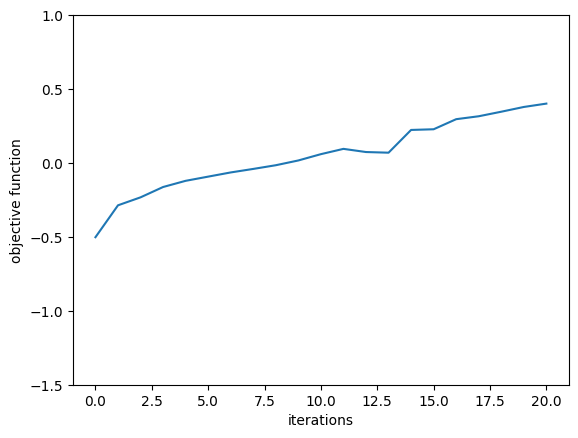

In [41]:
plt.plot(Js)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.ylim(-1.5, 1)
plt.show()


We grab the final design parameters and `beta` value.

In [28]:
params_final = params1_final, params2_final = params_history[-1]
beta_final = beta_history[-1]

And use these to construct the `Tidy3D` simulations corresponding to the final optimized state of each of the components.

In [29]:
sim1_final = make_sim(params1_final, beta=beta_final, source_index=0, shape=(1,2))
sim2_final = make_sim(params2_final, beta=beta_final, source_index=0, shape=(2,2))
sim3_final = make_sim(params2_final, beta=beta_final, source_index=1, shape=(2,2))


Let's plot these simulations. Note that the 3rd and 2nd are the same, except with different source, so we can visualize the fields sourced from each of the individual inputs.

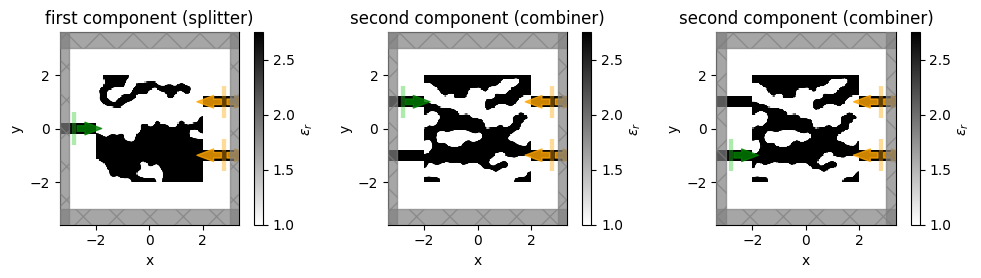

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10,6))

sim1_final.plot_eps(z=0, ax=ax1)
sim2_final.plot_eps(z=0, ax=ax2)
sim3_final.plot_eps(z=0, ax=ax3)

ax1.set_title('first component (splitter)')
ax2.set_title('second component (combiner)')
ax3.set_title('second component (combiner)')

plt.show()


To visualize the fields, let's create and add a `FieldMonitor` to each of the simulations.

In [31]:
field_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field_mnt",
    colocate=True,
)

sim1_final = sim1_final.copy(update=dict(monitors=(field_mnt,)))
sim2_final = sim2_final.copy(update=dict(monitors=(field_mnt,)))
sim3_final = sim3_final.copy(update=dict(monitors=(field_mnt,)))


Next, run the simulations

In [32]:
sims_final = (sim1_final, sim1_final, sim1_final)

sim_data1_final, sim_data2_final, sim_data3_final = tda.web.run_async(sims_final, path_dir="data", verbose=False)


and plot the results.

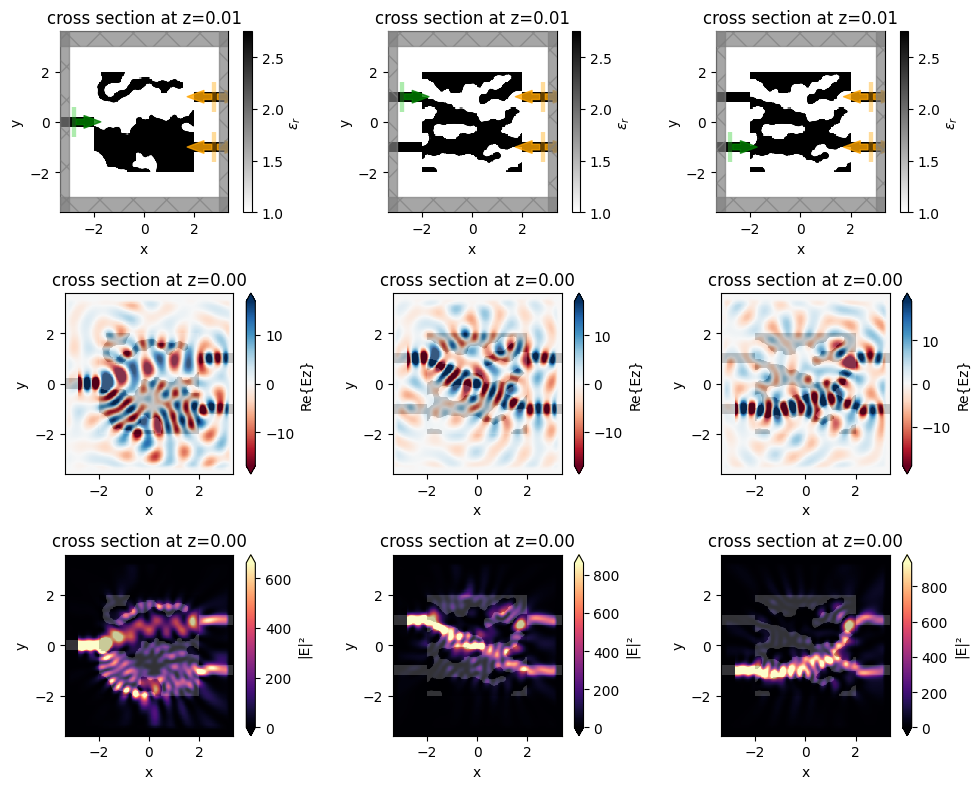

In [33]:
# f, ((ax_eps1, ax_eps2), (ax_fld1, ax_fld2), (ax_int1, ax_int2)) = plt.subplots(3, 2, figsize=(10, 6), tight_layout=True)
f, (axes_eps, axes_fld, axes_int) = plt.subplots(3, 3, figsize=(10, 8), tight_layout=True)
sim_datas = [sim_data1_final, sim_data2_final, sim_data3_final]
for sim_data_final, ax_eps, ax_fld, ax_int in zip(sim_datas, axes_eps, axes_fld, axes_int):
    sim_data_final.simulation.plot_eps(z=0.01, ax=ax_eps)
    sim_data_final.plot_field("field_mnt", "Ez", z=0, ax=ax_fld)
    sim_data_final.plot_field("field_mnt", "E", "abs^2", z=0, ax=ax_int)


While this gives an interesting picture, what we really want to visualize is how the fields look under our design conditions when `phi=0` and `phi=pi`. For that, we write a function to compute the source parameters for the 2nd component under values of `phi` and run that simulation.

In [34]:
def get_sim_data_right(phi):

    out_top_1 = sim_data1_final["top"].amps.sel(direction="+", f=freq0, mode_index=0)
    out_bot_1 = sim_data1_final["bot"].amps.sel(direction="+", f=freq0, mode_index=0)

    # apply phi phase shift to top arm
    phase_top = np.angle(out_top_1) + phi
    phase_bot = np.angle(out_bot_1)

    src_top = sim2_final.sources[0]
    src_bot = sim3_final.sources[0]
    
    src_time_top = src_top.source_time.updated_copy(amplitude=abs(out_top_1), phase=phase_top)
    src_time_bot = src_bot.source_time.updated_copy(amplitude=abs(out_bot_1), phase=phase_bot)
    
    src_top = src_top.updated_copy(source_time=src_time_top)
    src_bot = src_bot.updated_copy(source_time=src_time_bot)

    sim_right = sim2_final.updated_copy(sources=[src_top, src_bot])
    return tda.web.run(sim_right, task_name=f"phi={phi:.3f}")

We compute the field data for the output component for both `phi=0` and `phi=pi`.

In [35]:
sim_data_right_p0 = get_sim_data_right(phi=0)
sim_data_right_pi = get_sim_data_right(phi=np.pi)

[13:37:50] Created task 'phi=0.000' with task_id                                
           'fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1'.

           View task using web UI at                                            
           ]8;id=710052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=164857;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\taskId]8;;\]8;id=710052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\=]8;;\]8;id=113487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\fdve]8;;\]8;id=710052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\-942f6dbc-fd27-]8;;\
           ]8;id=710052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\475e-aba4-e11619e74fbbv1']8;;\.

Output()

[13:37:53] status = queued

Output()

[13:37:57] status = preprocess

[13:38:02] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get  
           the billed FlexCredit cost after a simulation run.

           starting up solver

           running solver

           To cancel the simulation, use 'web.abort(task_id)' or                
           'web.delete(task_id)' or abort/delete the task in the web UI.        
           Terminating the Python script will not stop the job running on the   
           cloud.

Output()

[13:38:09] early shutoff detected, exiting.

           status = postprocess

Output()

[13:38:13] status = success

           View simulation result at                                            
           ]8;id=411048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=187511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\taskId]8;;\]8;id=411048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\=]8;;\]8;id=501017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\fdve]8;;\]8;id=411048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\-942f6dbc-fd27-]8;;\
           ]8;id=411048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-942f6dbc-fd27-475e-aba4-e11619e74fbbv1\475e-aba4-e11619e74fbbv1']8;;\.

Output()

[13:38:15] loading SimulationData from simulation_data.hdf5

           Created task 'phi=3.142' with task_id                                
           'fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1'.

           View task using web UI at                                            
           ]8;id=181835;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=959120;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\taskId]8;;\]8;id=181835;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\=]8;;\]8;id=46175;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\fdve]8;;\]8;id=181835;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\-f25a1653-32cc-]8;;\
           ]8;id=181835;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\446e-ba6c-b036cc0503aev1']8;;\.

Output()

[13:38:18] status = queued

Output()

[13:38:22] status = preprocess

[13:38:28] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get  
           the billed FlexCredit cost after a simulation run.

           starting up solver

           running solver

[13:38:29] To cancel the simulation, use 'web.abort(task_id)' or                
           'web.delete(task_id)' or abort/delete the task in the web UI.        
           Terminating the Python script will not stop the job running on the   
           cloud.

Output()

[13:38:35] early shutoff detected, exiting.

           status = postprocess

Output()

[13:38:41] status = success

           View simulation result at                                            
           ]8;id=279704;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=505825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\taskId]8;;\]8;id=279704;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\=]8;;\]8;id=59164;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\fdve]8;;\]8;id=279704;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\-f25a1653-32cc-]8;;\
           ]8;id=279704;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f25a1653-32cc-446e-ba6c-b036cc0503aev1\446e-ba6c-b036cc0503aev1']8;;\.

Output()

[13:38:43] loading SimulationData from simulation_data.hdf5

And plot the results. Note that the device works exactly as intended! When `phi=0`, the light is transmitted into the top port and when `phi=pi`, the light is transmitted into the bottom port.

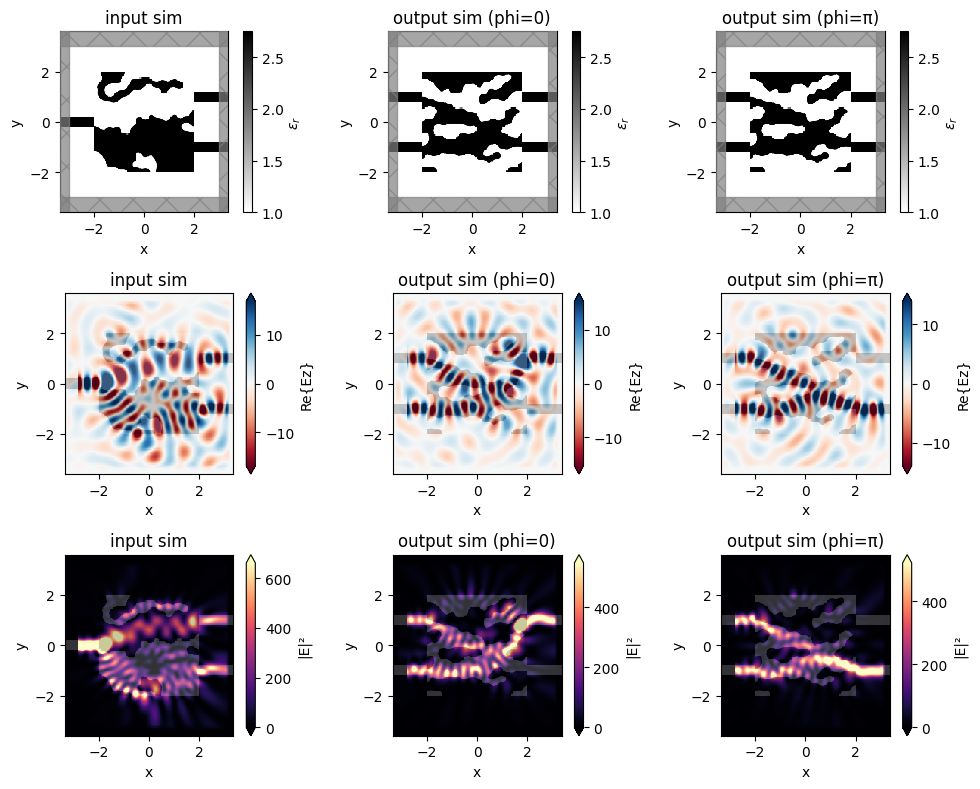

In [44]:
alpha = 0.0
f, (axes_eps, axes_fld, axes_int) = plt.subplots(3, 3, figsize=(10, 8), tight_layout=True)
sim_datas = [sim_data1_final, sim_data_right_p0, sim_data_right_pi]
for sim_data_final, ax_eps, ax_fld, ax_int, phi in zip(sim_datas, axes_eps, axes_fld, axes_int, (None, "0", "π")):
    sim_data_final.simulation.plot_eps(z=0.01, ax=ax_eps, source_alpha=alpha, monitor_alpha=0)
    sim_data_final.plot_field("field_mnt", "Ez", z=0, ax=ax_fld)
    sim_data_final.plot_field("field_mnt", "E", "abs^2", z=0, ax=ax_int)

    for ax in (ax_eps, ax_fld, ax_int):
        if phi is not None:
            ax.set_title(rf'output sim (phi={phi})')
        else:
            ax.set_title("input sim")


With some minor modifications to this MZI device (such as adding a 2nd input port and adding a 2nd phase shifter on the output), we can implement any unitary 2x2 matrix and build very complex components for performing arbitrary linear operations in optical circuits, such as [optical neural networks](https://www.nature.com/articles/nphoton.2017.93.). 

With the `adjoint` plugin of `Tidy3D` and the differentiable circuit modeling of `sax`, we have a convenient tool for combining the power and flexibility of inverse design with the modularity of traditional component design and can perform co-optimization of individual components with minimal overhead.